In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import matplotlib.pyplot as plt
from datasets import dataset_factory
import yaml
import os

In [5]:
# load sri image for the dataset
with open("configs/urban.yaml", 'r') as file:
    config = yaml.safe_load(file)
train_dataset = dataset_factory[config['dataset']['name']](
                **config['dataset']['kwargs'], mode="train", 
                transforms=None)
img_hsi = train_dataset.downsample(train_dataset.img_sri)
img_rgb, gt = train_dataset.img_rgb, train_dataset.gt
gt = train_dataset.downsample(gt)

In [9]:
import numpy as np

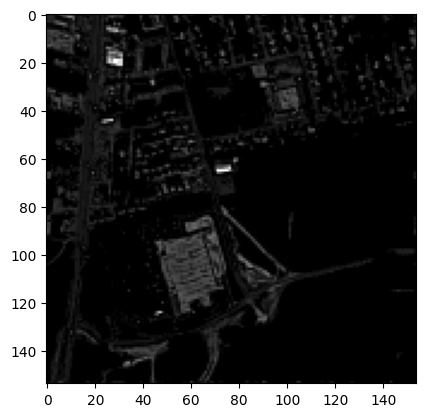

In [5]:
plt.imshow(img_hsi[:, :, 20], cmap="gray")
plt.show()

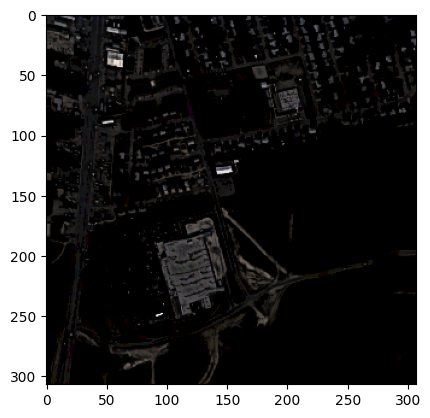

In [6]:
plt.imshow(img_rgb)
plt.show()

In [7]:
train_dataset.downsample(train_dataset.img_sri).shape

(154, 154, 162)

In [6]:
img_hsi_reshaped = img_hsi.reshape(-1, img_hsi.shape[-1])
gt_reshaped = gt.reshape(-1, gt.shape[-1])
print(img_hsi_reshaped.shape, gt_reshaped.shape)

(23716, 162) (23716, 6)


(23716,)
Class 0
(4649,)
Class 1
(8769,)
Class 2
(5907,)
Class 3
(1684,)
Class 4
(561,)
Class 5
(2146,)


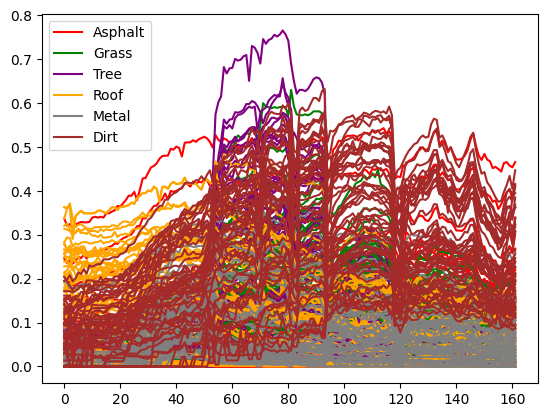

In [10]:
size_each_class = 50
colors = ['red', 'green', 'purple', 'orange', 'gray', 'brown']
label_names = ['Asphalt', 'Grass', 'Tree', 'Roof', 'Metal','Dirt']
num_classes = len(label_names)
indices = None
all_labels = np.argmax(gt_reshaped, axis=1)
print(all_labels.shape)
for c in range(num_classes):
    print('Class', c)
    indices_in_class = np.where(all_labels == c)[0]
    print(indices_in_class.shape)
    current_choices = np.random.choice(indices_in_class, size=size_each_class)
    if indices is None:
        indices = current_choices
    else:
        indices = np.append(indices, current_choices)
num_series = indices.shape[0]
num_pixels = img_hsi_reshaped.shape[0]
num_channels = img_hsi_reshaped.shape[1]
x =  np.arange(start=0, stop=num_channels, step=1)
cnt = 0
plotted = [False]*num_classes
for i in indices:
    color_index = all_labels[i]
    if not plotted[color_index]:
        plotted[color_index] = True
        plt.plot(x, img_hsi_reshaped[i], c=colors[color_index], label=label_names[color_index])
    else:
        plt.plot(x, img_hsi_reshaped[i], c=colors[color_index])
plt.legend()

In [11]:
from motion_code.motion_code import MotionCode
from motion_code.data_processing import load_data, process_data_for_motion_codes

all_num_series = img_hsi_reshaped.shape[0]
Y_train_all = img_hsi_reshaped.reshape(all_num_series, 1, -1)
Y_train = img_hsi_reshaped[indices, :].reshape(num_series, 1, -1)
labels_train_all = np.argmax(gt_reshaped, axis=1)
labels_train = np.argmax(gt_reshaped[indices, :], axis=1)
print(Y_train.shape, labels_train.shape)

# Then we process the data for motion code model and generate X-variable, which is needed for training.
X_train, Y_train, labels_train = process_data_for_motion_codes(Y_train, labels_train)
X_train_all, Y_train_all, labels_train_all = process_data_for_motion_codes(Y_train_all, labels_train_all)
print(X_train.shape, Y_train.shape, labels_train.shape)
print(X_train_all.shape, Y_train_all.shape, labels_train_all.shape)

(300, 1, 162) (300,)
(300, 162) (300, 162) (300,)
(23716, 162) (23716, 162) (23716,)


In [13]:
# Next we build the default motion code model for both forecasting and classification
model = MotionCode(m=12, Q=1, latent_dim=2, sigma_y=0.1)
# Then we train model on the given X_train, Y_train, label_train set and saved it to a file named test_model.
os.makedirs('motion_code/saved_models', exist_ok=True)
model_path = 'motion_code/saved_models/' + 'urban'
model.fit(X_train, Y_train, labels_train, model_path)

num_motion: 6


2024-07-29 23:04:01.285221: E external/xla/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module jit_elbo] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2024-07-29 23:27:02.372303: E external/xla/xla/service/slow_operation_alarm.cc:133] The operation took 25m1.087252357s

********************************
[Compiling module jit_elbo] Very slow compile? If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [4]:
from motion_code.motion_code import MotionCode
import os
model = MotionCode(m=12, Q=1, latent_dim=2, sigma_y=0.1)

In [5]:
model_path = 'motion_code/saved_models/test_model'
model.load(model_path)

In [6]:
os.makedirs("motion_code/out/multiple", exist_ok=True)

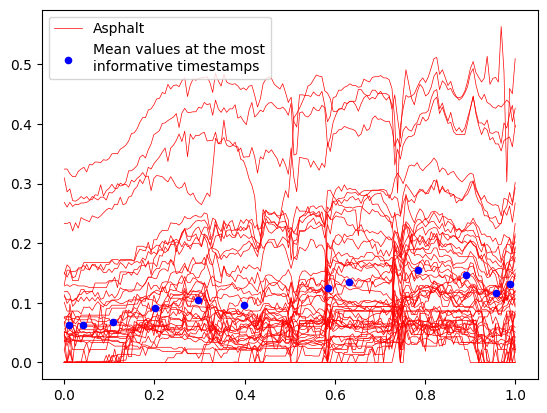

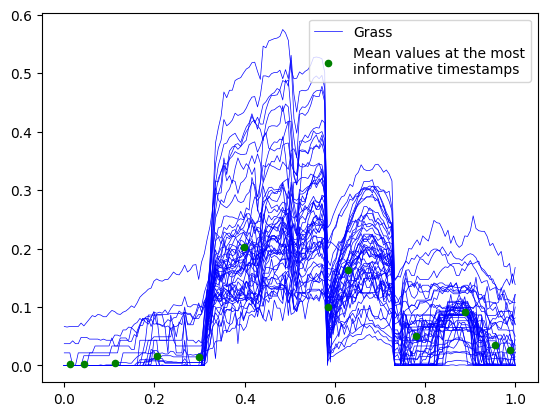

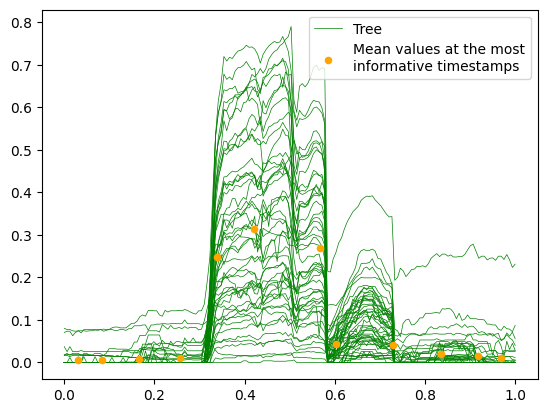

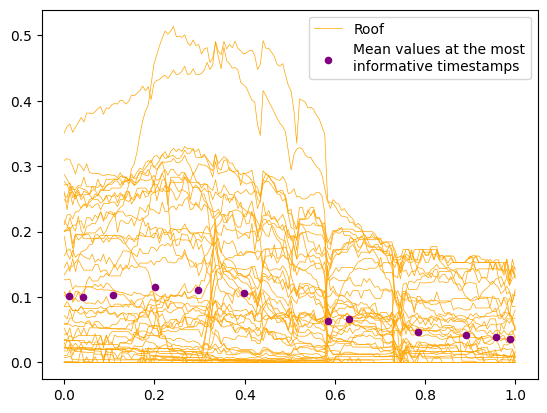

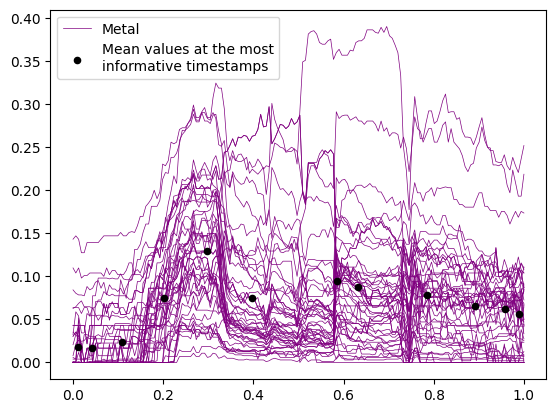

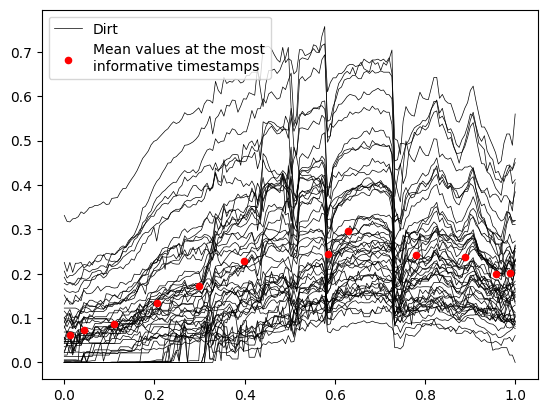

<Figure size 640x480 with 0 Axes>

In [17]:
from motion_code.utils import plot_motion_codes
plot_motion_codes(X_train, Y_train, test_time_horizon=None, labels=labels_train, label_names=label_names,
                           model=model, output_dir='motion_code/out/multiple/', additional_data=None)

In [13]:
model.Z.shape

(6, 2)

In [15]:
from motion_code.sparse_gp import sigmoid
import numpy as np
num_motion = len(label_names); m = 12
X_m, Z = model.X_m, model.Z
X_m_ks = [sigmoid(X_m @ Z[k]) for k in range(num_motion)]
X_m_ks = np.array(X_m_ks)
Y_means_at_X_m = np.zeros((num_motion, m))
Y_stds_at_X_m = np.zeros((num_motion, m))
Y_list_at_X_m = []
for _ in range(num_motion):
  Y_list_at_X_m.append([])
for X_s, Y_s, label in zip(X_train, Y_train, labels_train):
  Y_list_at_X_m[label].append(np.interp(X_m_ks[label], X_s, Y_s))
for k in range(num_motion):
  tmp = np.array(Y_list_at_X_m[k])
  Y_means_at_X_m[k] = np.mean(tmp, axis=0)
  Y_stds_at_X_m[k] = np.std(tmp, axis=0)

In [16]:
X_m_ks.shape

(6, 12)

In [21]:
X_m_ks[0] * 224

array([  2.55267938,   9.43378898,  24.1811506 ,  45.16517453,
        66.30533922,  89.09350518, 131.23924037, 141.46552733,
       175.77629581, 199.77521698, 214.70849414, 221.44011008])

In [22]:
Y_means_at_X_m[0]

array([0.0630897 , 0.06270978, 0.0676346 , 0.09067645, 0.10515744,
       0.09665046, 0.12575615, 0.1356006 , 0.15515067, 0.14661072,
       0.11735503, 0.13130269])

In [23]:
Y_means_at_X_m[1]

array([0.00250936, 0.00309421, 0.00476687, 0.01699485, 0.01512573,
       0.203233  , 0.10001938, 0.16263555, 0.04998095, 0.09151682,
       0.03433898, 0.02714261])

In [24]:
Y_means_at_X_m[2]

array([0.00488535, 0.00493267, 0.00747812, 0.01057404, 0.24738221,
       0.31360769, 0.26857109, 0.04236678, 0.04101736, 0.02010094,
       0.01484982, 0.01067951])

In [25]:
Y_means_at_X_m[3]

array([0.1021593 , 0.09970756, 0.10358444, 0.11533633, 0.11015171,
       0.10582318, 0.06285072, 0.06721011, 0.04659969, 0.0415123 ,
       0.03934321, 0.03538785])

In [26]:
Y_stds_at_X_m[1]

array([0.010936  , 0.01204616, 0.01599197, 0.03305066, 0.0349288 ,
       0.0974667 , 0.05220755, 0.06234972, 0.05502373, 0.0428087 ,
       0.0478484 , 0.04349484])

In [27]:
Y_means_at_X_m.shape

(6, 12)

In [28]:
from tqdm import tqdm

indices_set = [2, 3, 4, 5, 6, 7]

def classify_predict(X_test, Y_test, X_m_ks, Y_means_at_X_m, Y_stds_at_X_m,
                     num_motion, indices_set=indices_set):
    min_err = 1e9
    label = -1
    for k in range(num_motion):
        Y_tmp = np.interp(X_m_ks[k][indices_set], X_test, Y_test)
        err_arr = (Y_tmp - Y_means_at_X_m[k][indices_set]) #/Y_stds_at_X_m[k][indices_set]
        # print(err_arr.shape)
        err = np.mean(np.abs(err_arr))
        if err < min_err:
            min_err = err
            label = k
    return label

def classify_predict_on_batches(model, X_m_ks, X_test_list,
                                Y_test_list, true_labels,
                                Y_means_at_X_m,
                                Y_stds_at_X_m,
                                num_motion):
    # Predict each trajectory/timeseries in the test dataset
    num_predicted = 0
    pred = []; gt = []
    if isinstance(Y_test_list, list):
        num_test = len(Y_test_list)
    else:
        num_test = Y_test_list.shape[0]
    pbar = tqdm(zip(X_test_list, Y_test_list), total=num_test, leave=False)
    num_predicted = 0
    for X_test, Y_test in pbar:
        # Get predict and ground truth motions
        pred_label = classify_predict(X_test, Y_test, X_m_ks, 
                                      Y_means_at_X_m, Y_stds_at_X_m, num_motion)
        gt_label = true_labels[num_predicted]
        pbar.set_description(f'Predict: {pred_label}; gt: {gt_label}')
        # Append results to lists for final evaluation
        pred.append(pred_label); gt.append(gt_label)
        num_predicted += 1
    pred = np.array(pred); gt = np.array(gt)
    print(np.sum(pred==gt)/pred.shape[0])
    return pred, gt

In [30]:
# Prediction on data
# Now we can go on to perform prediction on the whole test set and get accuracy
pred, gt = classify_predict_on_batches(model, X_m_ks, X_train_all, Y_train_all,
                                       labels_train_all, Y_means_at_X_m,
                                       Y_stds_at_X_m, num_motion)

0.5312025636700961


In [31]:
pred, gt = np.array(pred).reshape(154, 154), np.array(gt).reshape(154, 154)

In [32]:
from matplotlib.colors import ListedColormap
cmap = ListedColormap(colors)

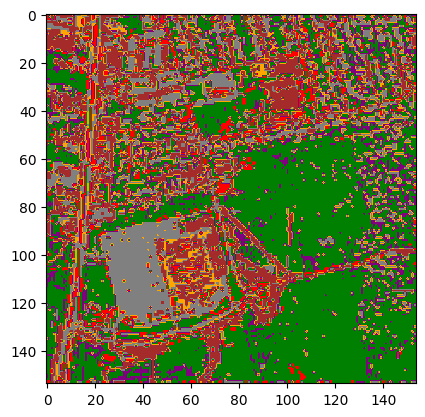

In [33]:
plt.imshow(pred, cmap=cmap)

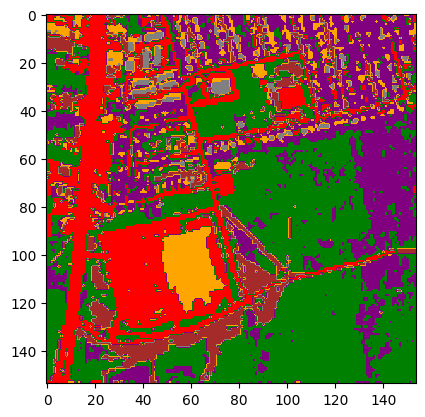

In [34]:
plt.imshow(gt, cmap=cmap)

In [ ]:
def get_compressed_matrix(): # H x W x 12